In [1]:
import math
import pypot.dynamixel
from pypot.dynamixel.conversion import dxl_code
from pypot.dynamixel.conversion import dxl_decode
from time import sleep, time

from lib import Motor
import control_tables
from utils import read_from_file, dxl_decode_value

import matplotlib
import matplotlib.pyplot as plt
from utils import write_in_file
import numpy as np

In [2]:
PORT = '/dev/ttyACM0'
with pypot.dynamixel.Dxl320IO(PORT) as dxl_io:
    ids = dxl_io.scan()
    print(ids)

[10, 11, 12, 13]


In [3]:
DXL_ID = 10
INPUT_TENSION = 12.78

configs = {
    "MX-106": {"resistance": 2.0, "torque_constant": 2.3593725498111775},
    "MX-64": {"resistance": 3.6, "torque_constant": 8.011176076962043},
}

In [4]:
# Lock all other motors
protocol_v2_motors = [11, 12, 13]
positions = [90, 180, 180]
with pypot.dynamixel.Dxl320IO(PORT) as dxl_io:
    for index, motor_id in enumerate(protocol_v2_motors):
        motor = Motor(
            dxl_io,
            motor_id,
            control_tables.MX_64,
            configs['MX-64']['resistance'],
            configs['MX-64']['torque_constant'],
            INPUT_TENSION
        )

        motor.torque_enabled = False
        motor.mode = 3
        motor.torque_enabled = True
        motor.goal_position = positions[index]

        print(f"Motor {motor_id} set")

Motor 11 set
Motor 12 set
Motor 13 set


In [5]:
# Setup shoulder
dxl_io = pypot.dynamixel.Dxl320IO(PORT)
motor = Motor(dxl_io, DXL_ID, control_tables.MX_106, configs['MX-106']['resistance'], configs['MX-106']['torque_constant'], INPUT_TENSION)

motor.torque_enabled = False
motor.mode = 16 # PWM Control mode
motor.torque_enabled = True
motor.motor_tension = 0

In [43]:
MASSE = 1.670 - 0.240  # Masse de l'objet en kg
DISTANCE = 0.45  # Distance de la masse à l'axe de rotation en mètres
GRAVITE = 9.81  # m/s²

couple_gravite = MASSE * DISTANCE * GRAVITE

In [44]:
# 0 -> 5 seconds : arm is static
# 5 -> 10 seconds : arm is moving slowly
# 10 -> end seconds : arm is moving fast

pos_current = np.array(read_from_file("pos_current_planned2.txt"))
pos_positions = np.deg2rad(np.array(read_from_file("pos_positions_planned2.txt")))
pos_times = np.array(read_from_file("pos_times_planned2.txt"))

We are conducting an experiment to study the negligible counter-electromotive force.

The following experiment is carried out: the motor is left stationary for five seconds, then rotated (by hand) slowly for five seconds, and finally rotated rapidly (again by hand) for five seconds. Measurements are taken of back EMF and current during this operation.
We obtain the following graph:

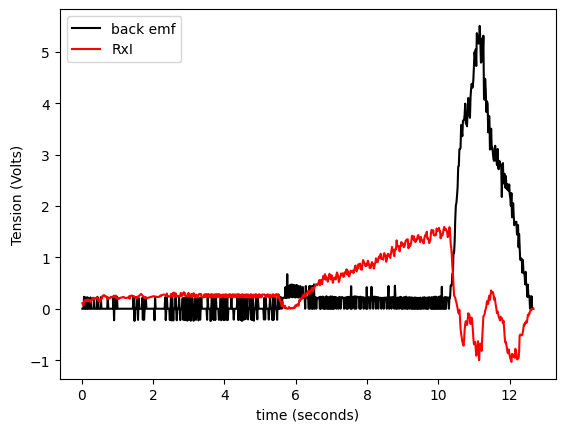

Vitesse limite = 0.0985 rad/sec (prop = 1.5716)
Date = 0.05898451805114746 (t = 3)
RxI = 0.1478 B EMF = 0.2324


In [45]:
speeds = np.array([(pos_positions[t] - pos_positions[t-1]) / (pos_times[t] - pos_times[t-1]) for t in range(1, len(pos_times))])
speeds = np.concatenate((np.array([0]), speeds))
back_emf = configs['MX-106']['torque_constant'] *  speeds
r_times_i = configs['MX-106']['resistance'] * pos_current

plt.figure()
plt.plot(pos_times, back_emf, color="black", label="back emf")
plt.plot(pos_times, r_times_i, color="red", label="RxI")

plt.xlabel("time (seconds)")
plt.ylabel("Tension (Volts)")
plt.legend()

plt.show()

eps = 1

for t in range(0, len(pos_times)):
    prop = abs(back_emf[t] / r_times_i[t])
    if prop > eps:
        print(f"Vitesse limite = {speeds[t]:.4f} rad/sec (prop = {prop:.4f})")
        print(f"Date = {pos_times[t]} (t = {t})")
        print(f"RxI = {r_times_i[t]:.4f} B EMF = {back_emf[t]:.4f}")
        break

The following can be noted: as soon as the motor is moving significantly, the counter-electromotive force is no longer negligible; in the phase between 10 and 15 seconds, the back EMF is about five times the value of $RI$ (in absolute value).

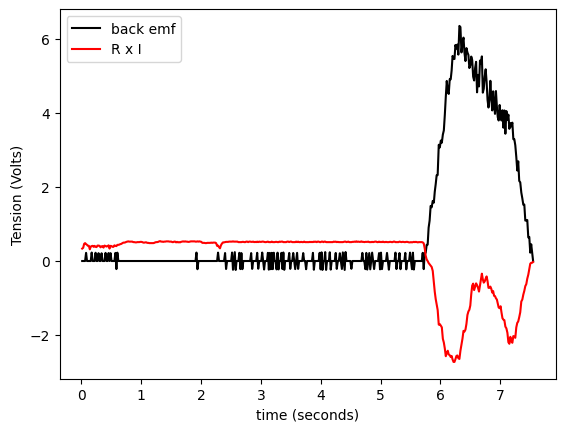

In [32]:
# 0 -> 5 seconds : arm is static
# 5 -> 7 seconds : arm is moving fast

pos_current = np.array(read_from_file("pos_current_planned3.txt"))
pos_positions = np.deg2rad(np.array(read_from_file("pos_positions_planned3.txt")))
pos_times = np.array(read_from_file("pos_times_planned3.txt"))

speeds = np.array([(pos_positions[t] - pos_positions[t-1]) / (pos_times[t] - pos_times[t-1]) for t in range(1, len(pos_times))])
speeds = np.concatenate((np.array([0]), speeds))
back_emf = configs['MX-106']['torque_constant'] *  speeds
r_times_i = configs['MX-106']['resistance'] * pos_current

plt.figure()
plt.plot(pos_times, back_emf, color="black", label="back emf")
plt.plot(pos_times, r_times_i, color="red", label="R x I")

plt.xlabel("time (seconds)")
plt.ylabel("Tension (Volts)")
plt.legend()

plt.show()

In [42]:
eps = 1

for t in range(0, len(pos_times)):
    prop = abs(back_emf[t] / r_times_i[t])
    if prop > eps:
        print(f"Vitesse limite = {speeds[t]:.4f} rad/sec (prop = {prop:.4f})")
        print(f"Date = {pos_times[t]} (t = {t})")
        print(f"RxI = {r_times_i[t]:.4f} B EMF = {back_emf[t]:.4f}")
        break

Vitesse limite = 0.0936 rad/sec (prop = 1.5651)
Date = 5.7530293464660645 (t = 351)
RxI = 0.1411 B EMF = 0.2209
